In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from src.preprocess_data import preprocess_data, clean_text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


In [3]:
df = pd.read_csv('data\\train.csv')
target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<BarContainer object of 6 artists>

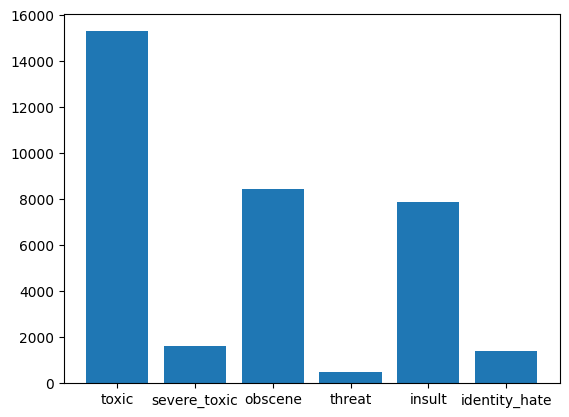

In [4]:
plt.bar(target, df[[x for x in target]].sum())

In [5]:
print(
    f'{df.shape[0]} total samples',
    f'{df[df[target].sum(axis=1) == 0].shape[0]} non-toxic samples',
    f'{df[df[target].sum(axis=1) > 0].shape[0]} toxic samples',
    f'{df[df[target].sum(axis=1) > 0].shape[0] / df.shape[0] * 100}% toxic samples', sep='\n' )

159571 total samples
143346 non-toxic samples
16225 toxic samples
10.167887648758233% toxic samples


Baseline:

TF-IDF + Logistic Regression / Linear SVM

In [6]:
l1 = df.iloc[0]['comment_text'].lower()
train_df = preprocess_data(df)
l2 = df.iloc[0]['comment_text']
l1, l2

("explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27",
 "Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27")

In [7]:
train_df, val_df  = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), preprocessor=clean_text)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])

model.fit(train_df['comment_text'], train_df[target])

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...001C46BF30E00>
,tokenizer,None


In [9]:
val_preds = model.predict(val_df['comment_text'])
val_probs = model.predict_proba(val_df['comment_text'])

print(f'Validation ROC-AUC Score: {roc_auc_score(val_df[target], val_probs)}')
print(classification_report(val_df[target], val_preds, target_names=target))

Validation ROC-AUC Score: 0.9710443590112909
               precision    recall  f1-score   support

        toxic       0.90      0.60      0.72      3056
 severe_toxic       0.58      0.25      0.35       321
      obscene       0.91      0.61      0.73      1715
       threat       0.79      0.15      0.25        74
       insult       0.84      0.50      0.63      1614
identity_hate       0.72      0.15      0.25       294

    micro avg       0.88      0.54      0.67      7074
    macro avg       0.79      0.38      0.49      7074
 weighted avg       0.87      0.54      0.66      7074
  samples avg       0.05      0.05      0.05      7074



d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [10]:
print(model.predict(["FUCK"]), model.predict(["F1ACK"]), model.predict(["F U C K"]))

[[1 1 1 0 1 0]] [[0 0 0 0 0 0]] [[0 0 0 0 0 0]]


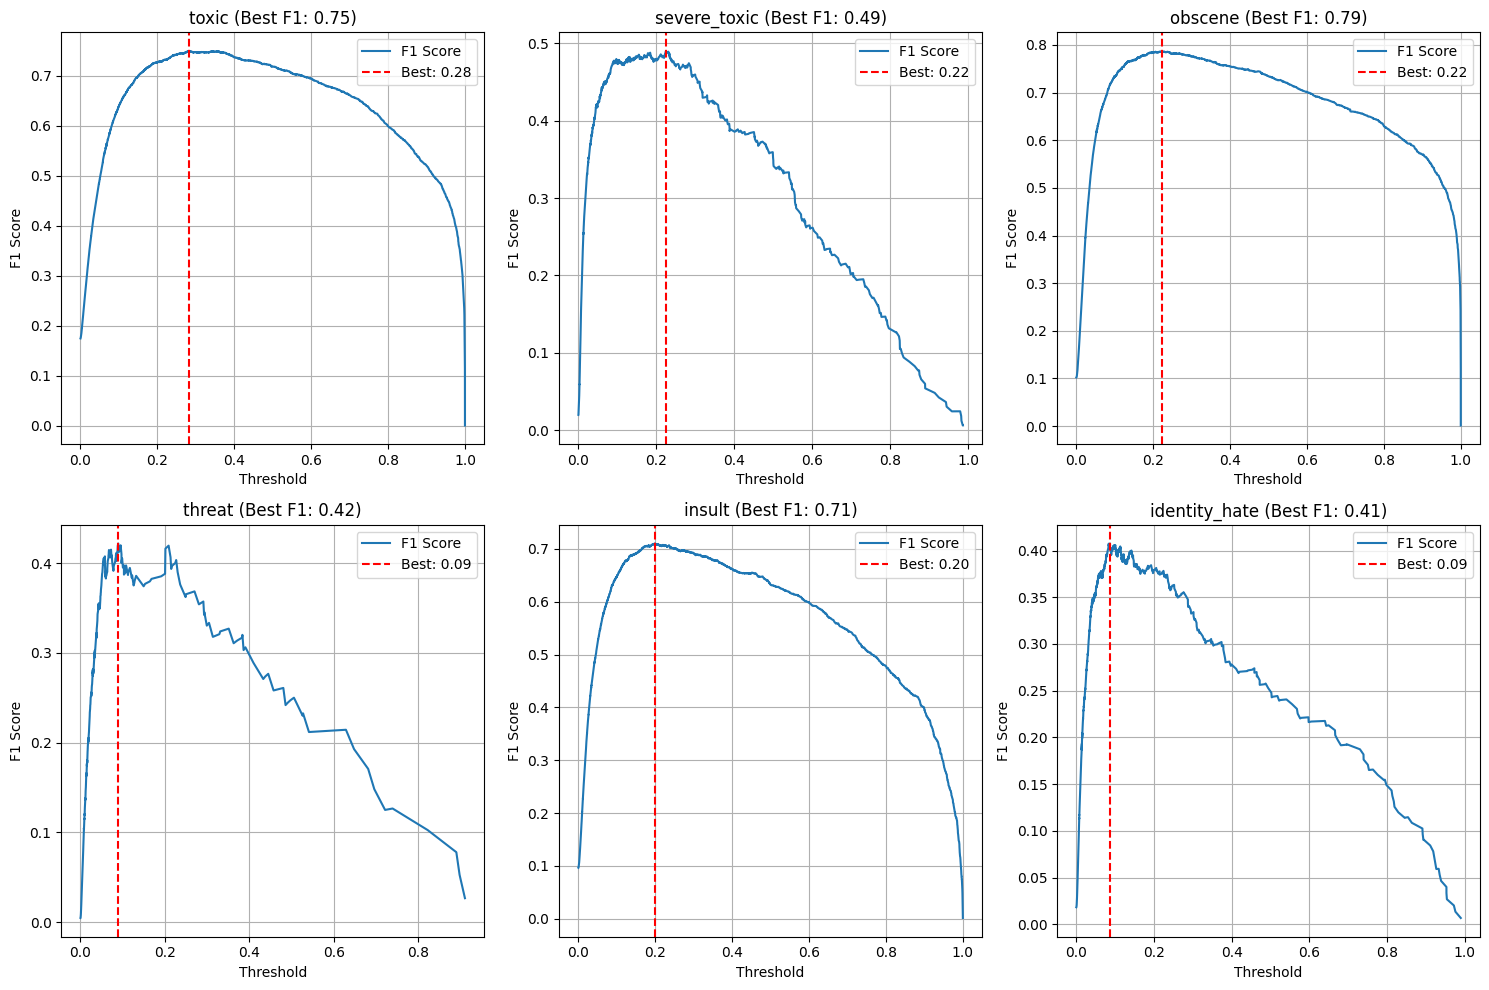

Optimal Thresholds (maximizing F1):
toxic: 0.2825
severe_toxic: 0.2246
obscene: 0.2224
threat: 0.0893
insult: 0.1986
identity_hate: 0.0868

Validation Classification Report with Optimized Thresholds:
               precision    recall  f1-score   support

        toxic       0.78      0.72      0.75      3056
 severe_toxic       0.49      0.49      0.49       321
      obscene       0.83      0.75      0.79      1715
       threat       0.38      0.47      0.42        74
       insult       0.68      0.74      0.71      1614
identity_hate       0.33      0.52      0.41       294

    micro avg       0.72      0.71      0.71      7074
    macro avg       0.58      0.62      0.59      7074
 weighted avg       0.73      0.71      0.72      7074
  samples avg       0.06      0.06      0.06      7074



d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
from sklearn.metrics import precision_recall_curve

optimal_thresholds = {}

plt.figure(figsize=(15, 10))

for i, col in enumerate(target):
    # Вычисляем кривую точности-полноты (precision-recall curve)
    precision, recall, thresholds = precision_recall_curve(val_df[col], val_probs[:, i])
    
    # Считаем F1-меру для каждого порога
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Убираем последнюю точку (она соответствует порогу 1.0)
    current_f1_scores = f1_scores[:-1]
    best_idx = np.argmax(current_f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = current_f1_scores[best_idx]
    
    optimal_thresholds[col] = best_threshold
    
    # Строим график F1 score от Threshold
    plt.subplot(2, 3, i+1)
    plt.plot(thresholds, current_f1_scores, label='F1 Score')
    plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best: {best_threshold:.2f}')
    plt.title(f'{col} (Best F1: {best_f1:.2f})')
    plt.xlabel('Порог (Threshold)')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

print("Оптимальные пороги (максимизирующие F1):")
for col, thr in optimal_thresholds.items():
    print(f"{col}: {thr:.4f}")

# Применяем новые пороги к предсказаниям
val_preds_optimized = np.zeros(val_probs.shape)
for i, col in enumerate(target):
    val_preds_optimized[:, i] = (val_probs[:, i] >= optimal_thresholds[col]).astype(int)

print("\nОтчет о классификации с оптимизированными порогами:")
print(classification_report(val_df[target], val_preds_optimized, target_names=target))